# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [48]:
import numpy as np
import emcee
import corner


/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

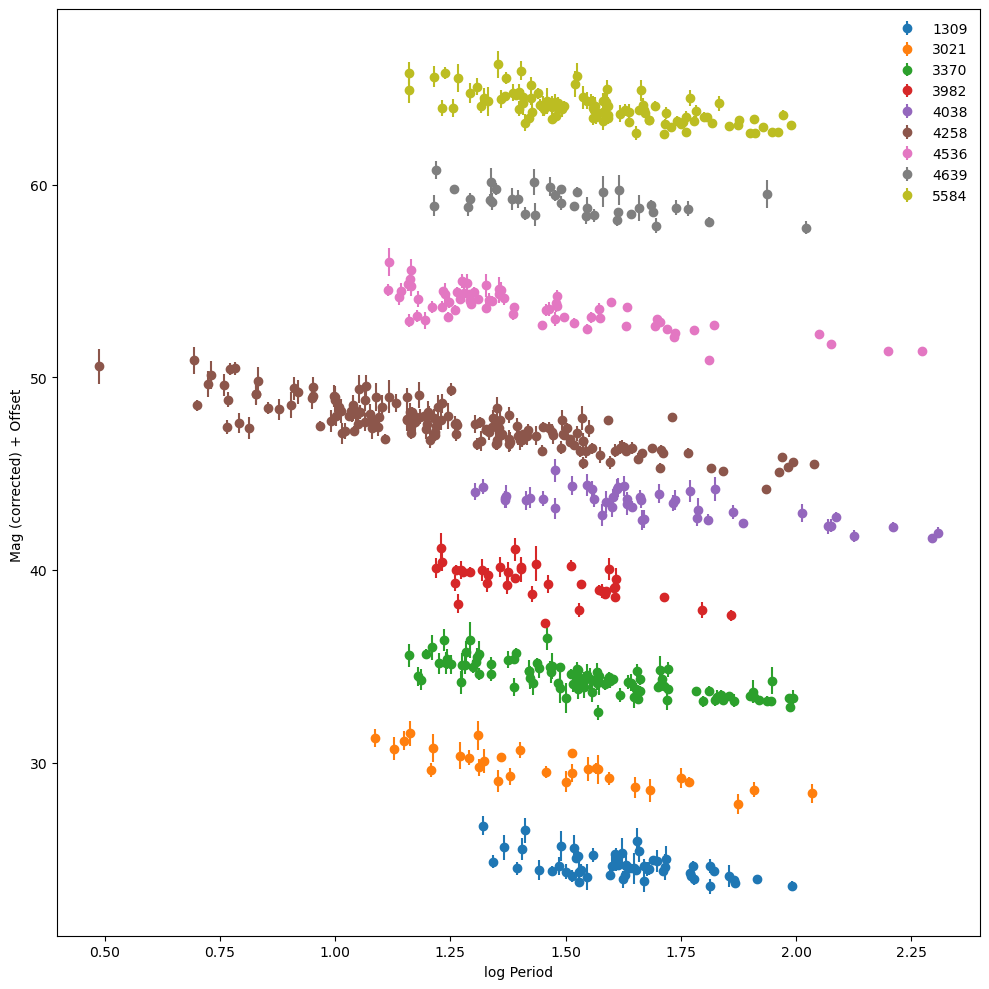

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

In [16]:
ceph.select(ceph.list_hosts()[0])
ceph.mobs

array([26.7371, 24.8681, 25.6012, 24.5263, 25.513 , 26.4842, 24.4343,
       24.384 , 24.6338, 25.6938, 24.35  , 24.1181, 25.5728, 25.0581,
       25.1307, 24.3153, 23.7843, 24.4089, 24.0502, 25.2102, 24.1851,
       24.6213, 25.2584, 24.9851, 24.669 , 25.2958, 23.9438, 24.1548,
       24.6115, 24.6615, 24.5543, 24.5168, 24.4348, 25.9261, 25.4302,
       24.64  , 23.8479, 24.4827, 24.4964, 24.9325, 24.8927, 24.3984,
       24.5884, 25.0118, 24.2861, 24.121 , 24.6163, 23.9628, 24.6279,
       23.5731, 24.3938, 24.1202, 23.9133, 23.7674, 23.971 , 23.5964])

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


---

The equation in question (Eq 1 from Riess et al. 2011),

$$ \large m_{W,i,j} = (\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258} + b_W \log P_{i,j}$$

Where,

- $ m_{W,i,j}$ is the magnitude observed
- $(\mu_{0,i} - \mu_{0,4258})$ are the Reddening Free Distances for the hosts relative to NGC 4258 
- $z p_{W,4258}$ is the intercept of the P–L relation simultaneously fit to the Cepheids of NGC 4258 **DO WE CARE ABOUT THIS?**
    - The [P-L relation](https://en.wikipedia.org/wiki/Period-luminosity_relation)
- $b_W \log P_{i,j}$ is the nuisance parameter $b$ multiplied by the log of the period 

What is this???

```python
def negative_log_likelihood(self, theta):
        """
        Computes -log L(theta)

        Parameters
        ----------
        theta : float, ndarray
            parameters being fitted, (a,b)

        Returns
        -------
        0.5 * chisq
        """
        a, b = theta[0], theta[1]
        chisq = np.sum(((self.mobs - a * self.logP - b) / self.sigma)**2)
        return 0.5 * chisq
```

So it should be,

$$ \sum \left(\frac{m_\text{obs} - a \log P -b}{\sigma}\right)^2$$

Thus, where $n$ is the number of Cepheids ($j$) per $i^\text{th}$ Galaxy and $N$ is the number of galaxies,

$$-\chi^2 =\sum_{i=1}^{N} \sum_{j=1}^n \left(\frac{m_{W,i,j} - b_W \log P_{i,j} -((\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258})}{\sigma_j}\right)^2$$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

---
I don't know buddy... trying to figure out a prior for $\alpha$ where $\alpha = (\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258}$

- 0.5 to 10

For $b_W$ we can assume a negative number via Homework #1 and magnitudes from -0.5 to -5

In [19]:
np.log10(49.97*1000/10)*5

18.493546747212935

In [34]:
np.log10(200/10)*5 -np.log10(10/10)*5

6.505149978319906

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [123]:
import astropy.units as u
import astropy.constants as const
def zfun(z,h0):
    h0 = h0*(u.km/(u.s*u.Mpc))
    val = z*const.c/h0
    return val.to(u.pc).value
def dmod(d):
    return 5*np.log10(d)-5

In [122]:
for i in range(len(hosts)):
    print(zfun(ceph.redshifts[hosts[i]]))

30514589.475000005
22013331.915999997
18270208.9404
15841890.030600002
23456618.4638
6398427.6036
25829261.631399997
14539934.213
23400942.7216


In [125]:
np.zeros((10,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [129]:
def genb():
    b1=np.zeros((len(hosts),2))
    for i in range(len(hosts)):
        b1[i,0] = dmod(zfun(ceph.redshifts[hosts[i]],50))
        b1[i,1] = dmod(zfun(ceph.redshifts[hosts[i]],90))
    return b1

In [130]:
bounds =genb()
bounds

array([[33.15317784, 31.87681531],
       [32.44406909, 31.16770656],
       [32.03935775, 30.76299522],
       [31.72967515, 30.45331262],
       [32.5819672 , 31.30560467],
       [29.76100648, 28.48464395],
       [32.79120014, 31.51483761],
       [31.54345239, 30.26708986],
       [32.57680695, 31.30044442]])

In [114]:
def logPrior(theta):
    re = []
    for i in range(len(theta)-1):
        # this uniform prior will be gone soon
        if theta[i] >= 5*np.log10(46*1000/10)+10 or theta[i]<=5*np.log10(46*1000/10)-10:
            re.append(-np.inf)
        else:
            re.append(0)
    
    if theta[-1]<= -10 or theta[-1]>=-0.5:
        re.append(-np.inf)
    else:
        re.append(0)
    return np.sum(re)

def LogPosterior(theta):
    cs=[]
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        wack = [theta[-1],theta[i]]
        cs.append(-ceph.negative_log_likelihood(wack))
    lnlike = np.sum(cs)
    lnprior=logPrior(theta)
    return lnlike+lnprior
    

In [115]:
ndim=len(hosts)+1 #number of hosts plus b_W
nwalkers=20
ig=np.zeros((nwalkers,len(hosts)+1))
ig[:,np.arange(len(hosts))]=np.random.uniform(0.5,30,(nwalkers,len(hosts)))
ig[:,-1] = np.random.uniform(-10,-0.5,(nwalkers))

In [116]:


sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(ig,1000,progress=True);

  0%|                                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.82it/s]


In [117]:
sam=sampler.get_chain(flat=True)

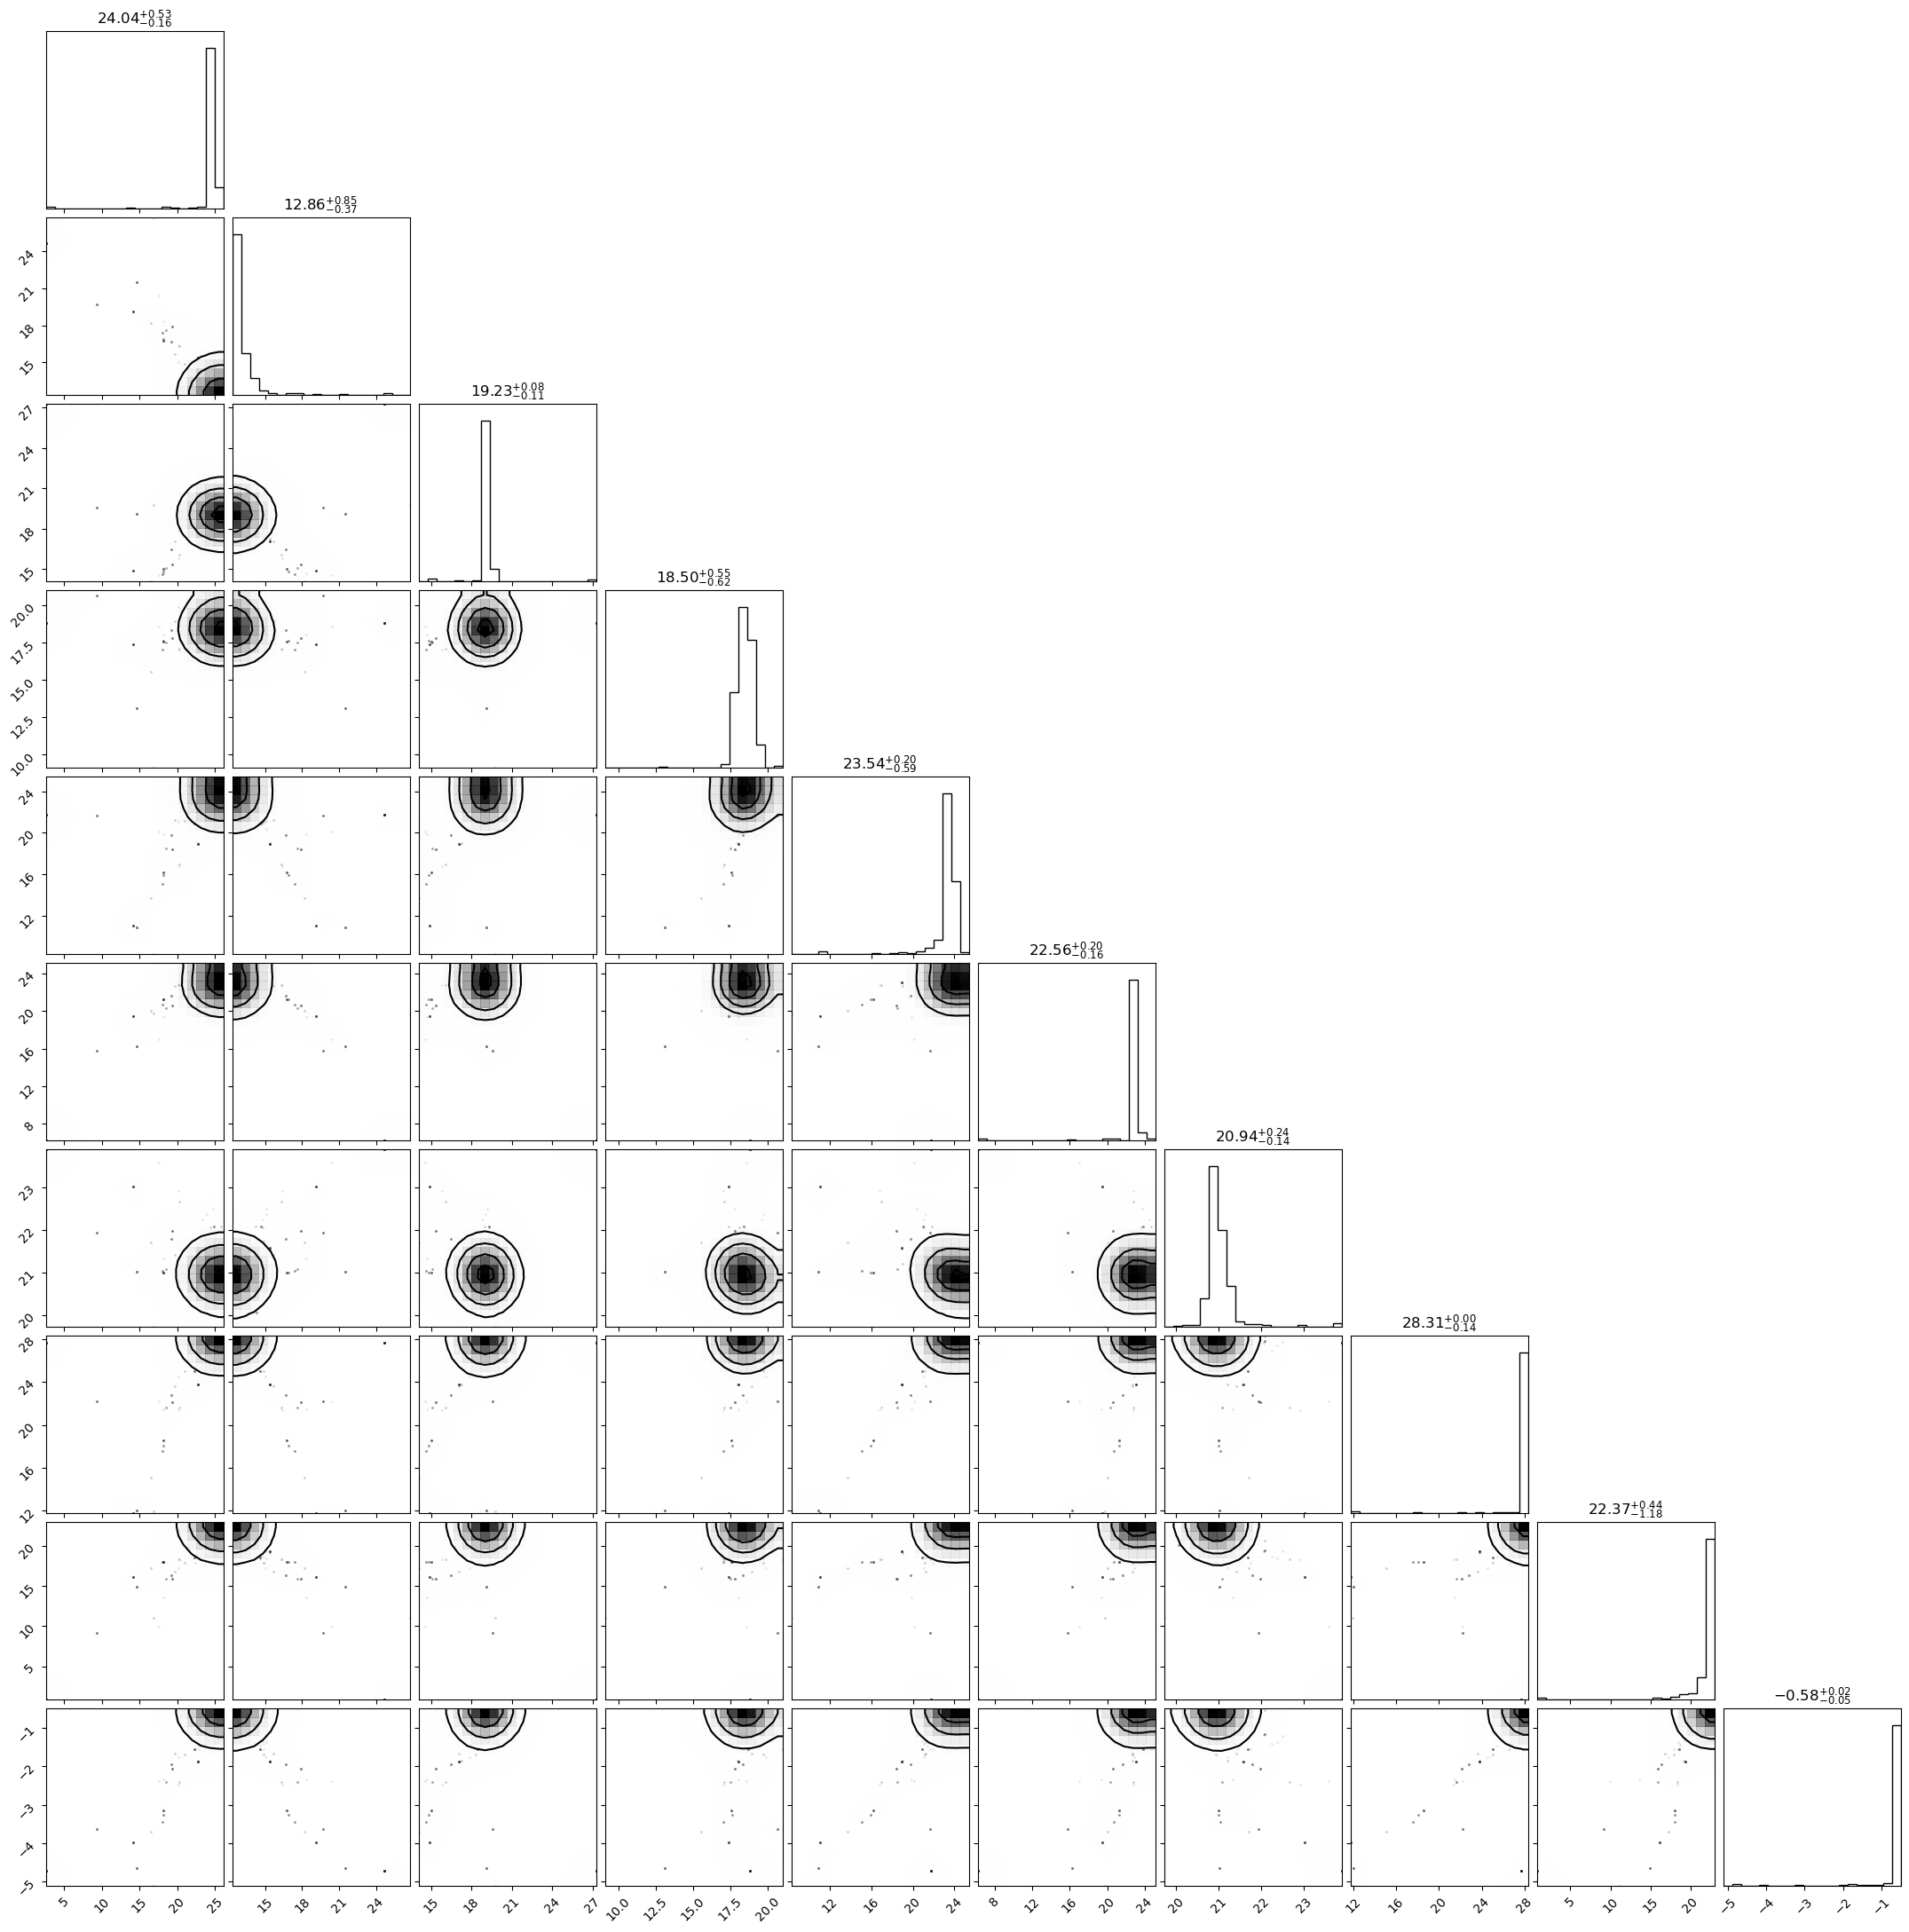

In [118]:
corner.corner(sam[::10], plot_contours=True, show_titles=True, smooth=2);

In [95]:
def func(x,m,b):
    return m*x+b

In [111]:
med =np.median(sam[::10],axis=0)
med

array([23.37606413, 18.72883079, 25.16073016, 23.02753924, 20.6548917 ,
       22.15390338, 23.85504879, 26.28412103, 26.01845419, -0.53179967])

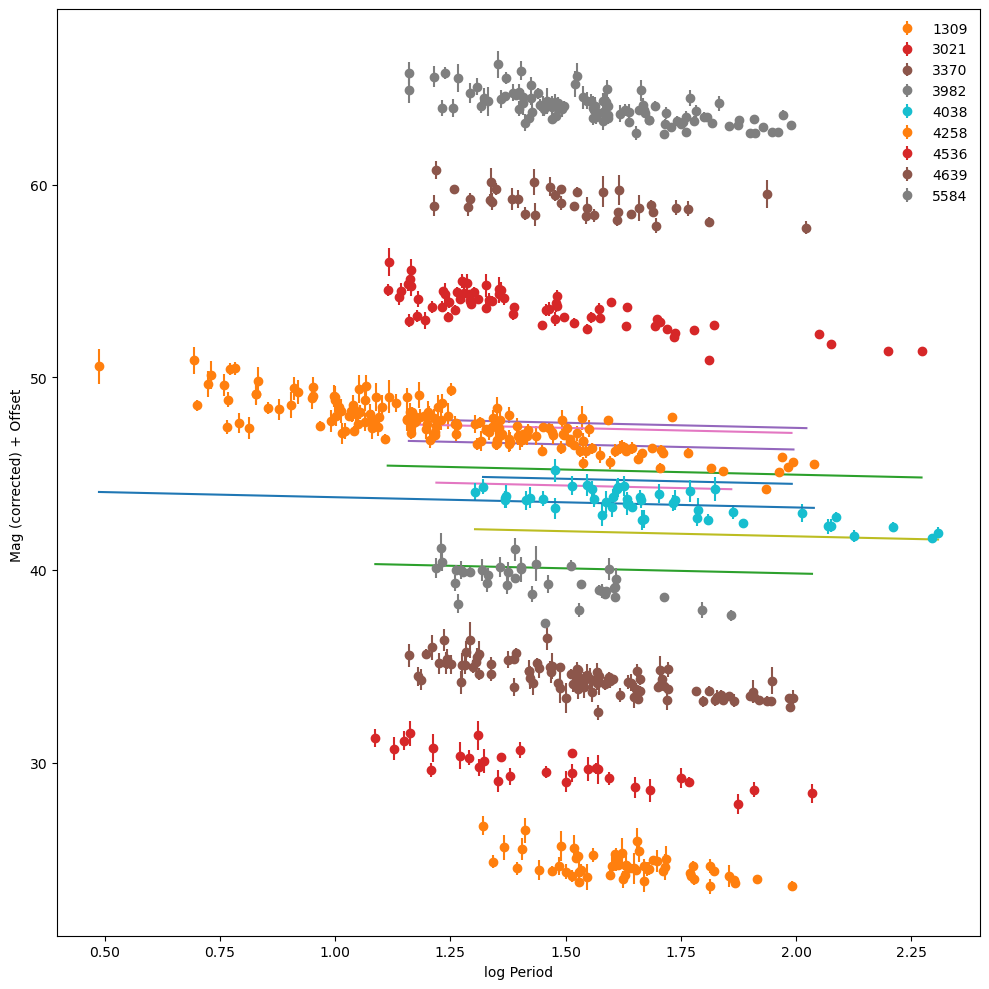

In [113]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    xv=np.linspace(logP.min(),logP.max(),1000)
    ax.plot(xv,func(xv,med[-1],med[i]+med[5]))
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.